![Image](./resources/cropped-SummerWorkshop_Header.png)

<h1 align="center">Population Coding: Part 2</h1> 
<h2 align="center"> Day 2, Afternoon Session</h2> 

<h3 align="center">Tuesday, August 22, 2023</h3> 

<br>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> The Questions </h2>
    
<p> The first week of the course is devoted to question focused workshops and addresing those questions with datasets and computational methods that we will present.  Each day will be devoted to its own question:  
    

<li> Day 1:  How do single neurons encode information about the external world?  
<b><li> Day 2:  How do populations of neurons encode information about the external world? </b>
<li> Day 3:  How do cell type and circuit architecture contribute to physiological function?
<li> Day 4:  What is a behavioral state and how can we define it? 
<li> Day 5:  How does network structure lead to network dynamics?

## Introduction

In the earlier workshop from today, we learned how to prepare multi-cellular neurophysiology data for use with a `scikit-learn` classifier. We then used two classifiers (SVM and Random Forest) to decode stimulus orientation from population responses.

In this tutorial, we will recap methods for accessing the Allen Brain Observatory Neuropixels dataset. We will then look at the impact of **correlated activity** on stimulus decoding. Neurons do not exist in isolation, and it's important to consider how stimulus classification is affected when we account for redundancies in the population code.

First, let's import some of the packages we'll need:

In [2]:
import numpy as np # used for creating and manipulating arrays

import matplotlib.pyplot as plt # used for plotting data
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # don't show warning for this tutorial

And setting the path to the data, depending on where we're running the code:

In [3]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

## Loading Neuropixels data for one session

Since we're analyzing data in the cloud, the public S3 bucket containing all of the data files is already mounted. So we just need to make sure the `EcephysProjectCache` object is aware of the location where the data is stored:

In [4]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

manifest_path = os.path.join(data_root,'allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json') 

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Now we can load data for the same session we used last time:

In [5]:
session_id = 798911424

session = cache.get_session_data(session_id)

We'll also load the table of unit metrics for the `brain_observatory_1.1` session type:

In [6]:
unit_metrics = cache.get_unit_analysis_metrics_by_session_type('brain_observatory_1.1')

Let's load our units table and filter for the units in primary visual cortex (`VISp`):

In [7]:
units = session.units # can be slow -- needs to load all spike times
units_VISp = units[units.ecephys_structure_acronym == 'VISp']
unit_metrics_VISp = unit_metrics.loc[units_VISp.index.values]

And our stimulus presentations table, using the fix described in the previous tutorial:

In [8]:
from allensdk.brain_observatory.ecephys.stimulus_table import naming_utilities

def passthrough_function(input):
    return input

naming_utilities.standardize_movie_numbers = passthrough_function
session.naming_utilities = naming_utilities # this is needed to circumvent a bug in the AllenSDK

stimulus_presentations = session.stimulus_presentations

Now we can construct our matrix of normalized firing rates for all V1 units and all drifting gratings trials:

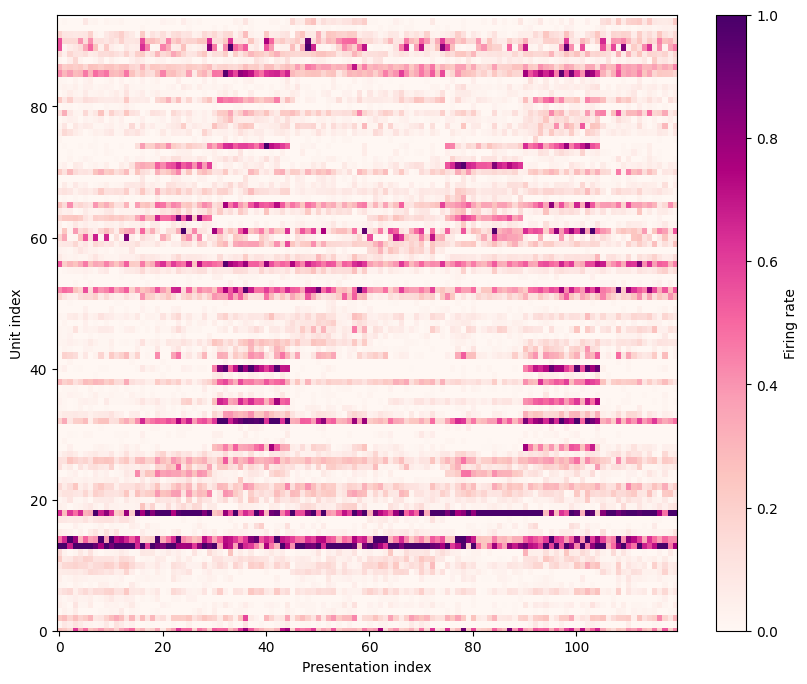

In [9]:
stimulus_presentations_dg = stimulus_presentations[stimulus_presentations.stimulus_name == 'drifting_gratings']

presentations = stimulus_presentations_dg[
            (stimulus_presentations_dg.temporal_frequency == 2.0)]

presentations = presentations.sort_values(by='orientation')
unit_ids = unit_metrics_VISp.sort_values(by=['pref_ori_dg']).index.values
        
da = session.presentationwise_spike_counts(np.arange(0,1.99,0.01), presentations.index.values, unit_ids)

plt.figure(figsize=(10,8))

firing_rates = da.sum('time_relative_to_stimulus_onset').T / 2
max_rates = firing_rates.max('unit_id')
norm_firing_rates = firing_rates / np.tile(max_rates, (len(unit_ids),1))

plt.imshow(norm_firing_rates, cmap='RdPu', aspect='auto', vmax=1)
plt.xlabel('Presentation index')
plt.ylabel('Unit index')
plt.colorbar(label='Firing rate', aspect=20)
_ = plt.ylim([0, len(unit_ids)])

## Exploring correlations between neurons

Based on the plot above, it's clear that neurons are correlated with one another. For example, look at units 35-40 and notice how they tend to have high firing rates or low firing rates on similar trials.

We'll look at this correlation in much more detail below, but we should first note some assumptions. Primarily, we are studying *spike counts*, or rates within time windows defined by the stimulus. This assumes that all spikes within the windows are equivalent, no matter their relative timing. It also assumes a specific set of time windows (set by the stimulus). In some cases, these assumptions may not be desirable (e.g., in studies of time-lagged spike-spike correlation, frequently used in studies of functional connectivity.)

With that tangent aside, let's return to our observation that the neurons' activities (defined here by spike rates) are correlated.

The activities of correlated neural populations have a *lower dimensionality* than the number of neurons. For example, for two perfectly correlated neurons, a single number suffices to describe both of their firing rates. This same idea applies to larger populations, and to less-than-perfect correlations.

To explore this property, we will apply the most common dimensionality reduction technique in existence to these data: Principal Component Analysis (PCA). This is a linear dimensionality reduction method (more on this later), and it works by considering the space of all possible neuron responses, wherein each axis of the space is a single neuron's firing rate. PCA finds the directions in this space along which the activities are the most spread out (highest variance) or the least spread out.

To understand PCA intuitively, consider this whale shark (borrowed shamelessly from [Allison Horst](https://twitter.com/allison_horst)):

<img src="https://raw.githubusercontent.com/AllenInstitute/swdb_2022/bf7f86e7c6c4db4a3a2e78d0e35b50dfcc45c9ae/resources/PCAWhale1.png" alt="Whale Shark" />


Now, imagine that the whale shark needs to eat this school of krill:

<img src="https://raw.githubusercontent.com/AllenInstitute/swdb_2022/bf7f86e7c6c4db4a3a2e78d0e35b50dfcc45c9ae/resources/PCAWhale2.png" alt="Krill Pic" />

Principal Component Analysis provides an algorithm that the shark can use to maximize how many krill will end up in its mouth. If the shark swims in the upward diagonal direction (the direction of maximum variance), they get the most krill.

To see how this works, lets start by imaging that the shark has a couple of footballs (this is, obviously, a super realistic example). To find the widest dimension of krill the shark will need to engulf, they can try to hold a football such that it entirely covers the krill population. The widest dimension will be the one in which the smallest football can cover all of the krill. Another way of saying this is that the football needs to be positioned to minimize the travel of any given krill trying to leave it.

<img src="https://raw.githubusercontent.com/AllenInstitute/swdb_2022/bf7f86e7c6c4db4a3a2e78d0e35b50dfcc45c9ae/resources/KrillPlot1.png" alt="Footballs 1" />

<img src="https://raw.githubusercontent.com/AllenInstitute/swdb_2022/bf7f86e7c6c4db4a3a2e78d0e35b50dfcc45c9ae/resources/KrillPlot2.png" alt="Footballs 2" />


Mathematically, the vector of the long axis of this football is the first eigenvector of the covariance matrix of the data, that is, the vector that describes the most variance in our data/krill. In Principal Component Analysis, this is called the first principal component. The amount the shark needs to resize the football is proportional to a quanitity know as the first eigenvalue.

Now that the whale shark has established this first vector, the next step is to establish a second. This is done by compressing all of the krill along the vector established by the first football, then fitting a second football to the remaining data.

## Computing the principal components of our firing rate matrix

To see how this works in a more mathematically rigorous way, we'll define the covariance matrix of the neural activity. For *N* neurons, this is an *N* x *N* matrix, the elements of which tell us how much any two neurons' activities (in this case, measured by their firing rates) tend to go up and down together.

Formally, if neurons *i* and *j* have firing rates $r_i$ and $r_j$, the elements of the covariance matrix are $C_{ij} = \left< (r_i - \overline{r_i})(r_j - \overline{r_j}) \right>$, where $\overline{r_i}$ is the mean firing rate of neuron *i* over all presentations.

We can compute this matrix easily using `numpy.cov`:

Text(0, 0.5, 'Unit #')

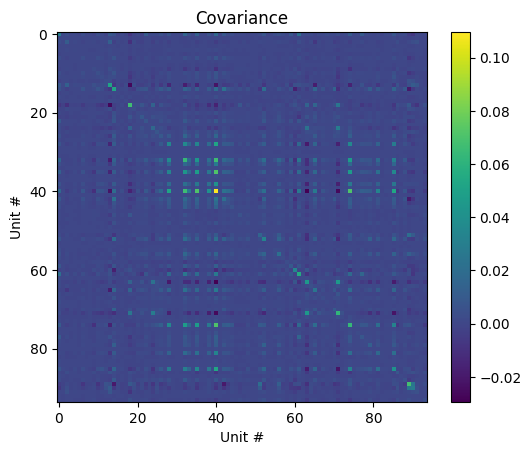

In [11]:
cov_mat = np.cov(norm_firing_rates) # covariance matrix of firing rates across units



plt.imshow(cov_mat)
plt.colorbar()
plt.title('Covariance')
plt.xlabel('Unit #')
plt.ylabel('Unit #')

We'll then use an eigenvalue decomposition to find the eigenvectors and eigenvalues of this matrix. Recall that, in general, for matrix $M$, a vector $\vec{v}$ is an eigenvector of that matrix, if $M \vec{v} = \lambda \vec{v}$, where $\lambda$ is a scalar (just a number). All square matrices (of shape NxN) have eigenvectors, and there will usually be *N* of them for an *N* x *N* matrix.

For symmetric matrices (like covariance matrices), all the eigenvectors will be orthogonal. For positive semi-definite matrices (like covariance matrices), all the eigenvalues will be greater than or equal to zero.

For covariance matrices, each eigenvector is called a Principal Component (PC) of the data, and each one represents a different direction in neural response space. The corresponding eigenvalues tell you the variance of the neural activities along that PC. 

In our krill example, the first eigenvector (with the largest eigenvalue) will be the upward-right-sloping diagonal line, while the second eigenvector would be the orthogonal direction (the downward-right-sloping diagonal line).

We can calculate these Principal Components using the `sklearn.decomposition.PCA` function, but I prefer to use the the `numpy.linalg.eig` function. This function returns the eigenvectors (and eigenvalues) sorted in descending order by their corresponding eigenvalues. Doing it this way reminds us that: a) PCA is really just eigen-decomposition of the covariance matrix; and b) that we have this useful `linalg.eig` function we can use for other applications where we want to know eigenvector and eigenvalues (these happens a lot when analyzing dynamical systems, like neural circuit models):

In [12]:
eigenvalues, eigenvectors = np.linalg.eig(cov_mat) #u

Let's first look at the eigenvalues. 

Text(0, 0.5, 'Eigenvalue (Variance along the n^th PC)')

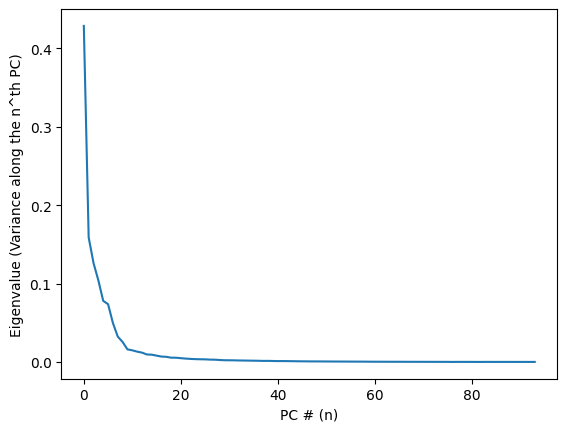

In [14]:
plt.plot(eigenvalues)
plt.xlabel('PC # (n)')
plt.ylabel('Eigenvalue (Variance along the n^th PC)')

As you can see, the eigenvalues come out of the `numpy.linalg.eig` function sorted from largest to smallest. The first ~20 eigenvalues are quite large (high variance), while the later ones are much smaller. We can see this more clearly by asking how much of the overall population activity is captured by the first *n* eigenvalues.

Text(0, 0.5, 'Fraction of Variance Explained')

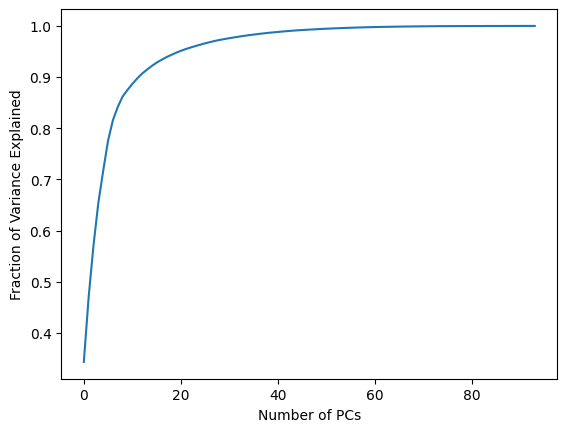

In [15]:
fraction_explained = np.cumsum(eigenvalues)/np.sum(eigenvalues)
plt.plot(fraction_explained)
plt.xlabel('Number of PCs')
plt.ylabel('Fraction of Variance Explained')

While the overall population has 94 neurons, we can capture ~90% of the variance in that population's activities with the first 12 principal components! Thus, the 94-element vectors of neural population activity are ~12 dimensional: they can be well-described using only 12 descriptors. Geometrically, this fact tells us that the population activity vectors all lie near a 12-dimensional hyperplane within the (94-D) space of all possible neural activities.

Importantly, PCA is a linear method: the low-dimensional manifolds it finds are hyperplanes. This means that low-dimensional structure in neural population activities that lies along curved manifolds may not be identified by PCA. For that reason, PCA-defined dimensionality is an upper bound on the true dimensionality of the population activity: there could always be lower-dimensional structures with nonlinear properties that PCA just can't find.

There exist many beautiful methods for finding low-dimensional nonlinear structure in neural data (and other kinds of data), including Isomap, Local Linear Embedding (LLE), and deep neural network autoencoders with bottlenecks. These are much more finicky than PCA.

Each eigenvalue is associated with an eigenvector. (Recall that, here, those correspond to directions in neural response space). For our krill example, those vectors were in 2dimensions and were easy to visualize. For our neural data, these are 94 element vectors. Let's look at the first of these.

Text(0, 0.5, 'Contribution to the first PC')

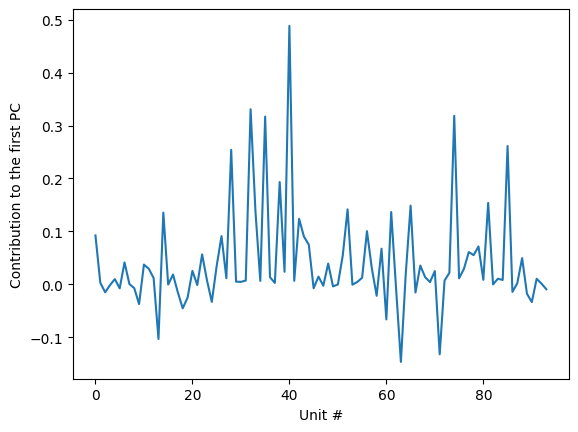

In [16]:
#First principal component: 
plt.plot(eigenvectors[:,0]) #first PC is the eigenvector with the largest eigenvalue 
plt.xlabel("Unit #")
plt.ylabel("Contribution to the first PC")

As you can see, each PC has contributions from many different neurons. 

To reduce the dimensionality of the data, while capturing as much variance as possible in the original (94-D) dataset, we simply project the recorded neural activity onto the first few PCs. For example, if we project the data onto the first two PCs, we retain 47% of the variance, and get the following simple 2D description of the data.

Because the covariance matrix operates on centered data (remember how the mean is subtracted from each neuron's activity in computing the covariance matrix whose eigenvectors are the PCs...), we need to first center the neural activity data by subtracting the means, and then project those activities onto the PC vectors:

In [17]:
#center the data -- similar to the rate normalization procedure described in tutorial 1
mean_rates = np.mean(norm_firing_rates,axis=1) #mean firing rate for each unit
centered_norm_firing_rates = norm_firing_rates - np.transpose(np.tile(mean_rates, (120,1))) #centered firing rates 

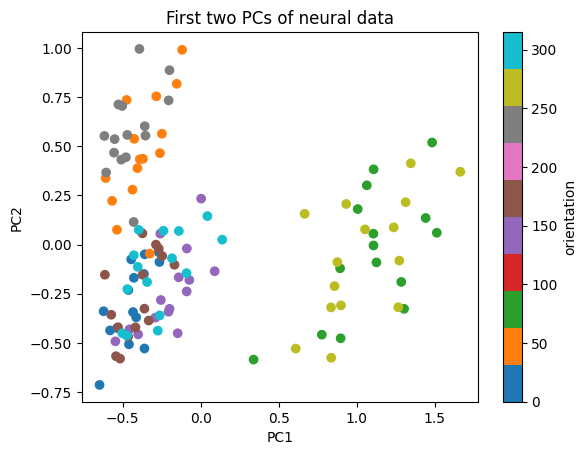

In [19]:
projections = np.dot(np.transpose(eigenvectors[:,0:2]),centered_norm_firing_rates) #calculate the dot product of the first two eigenvectors with the centered firing rates
orientations = presentations.orientation.values.astype('int') #get the orientation of each stimulus presentation 

plt.scatter(projections[0,:],projections[1,:],c=orientations, cmap='tab10')
plt.title('First two PCs of neural data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='orientation')

Each data point in this scatter plot is a single stimulus presentation, where the activities of the 94 neurons have been described by the first two PCs.

Note that responses to different pairs of stimulus directions tend to cluster together. This is because the drifting grating stimuli look quite similar when we rotate them by 180 degrees.

We can make this more explicit by color-coding the labels a different way, where we merge together the angles that differ by 180 degrees.

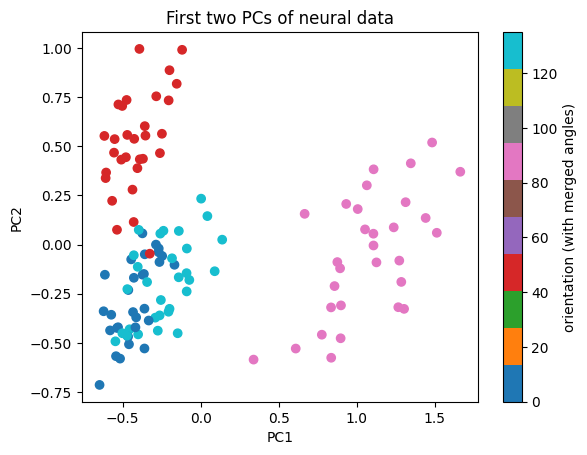

In [21]:
import copy
merged_orientations = np.copy(orientations) # make a copy of the orientations array
merged_orientations[60:] = merged_orientations[60:] - 180 #the first four of each sitmuli will be the same (15+15+15+15)

plt.scatter(projections[0,:],projections[1,:],c=merged_orientations, cmap='tab10')
plt.title('First two PCs of neural data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='orientation (with merged angles)')

Labeled this way, the clustering of responses by stimulus is much more clear.

## Computing correlation matrices

So far, we have looked at the covariance between neurons. For the following analysis, we will instead look at Pearson correlations instead of covariance: the Pearson correlation for a pair of neurons is the covariance divided by the product of the neurons' standard deviations. This normalizes the measure so that its maximum is 1 and minimum is -1, which makes it easier to interpret than covariances.

So far, we have not considered how much of the covariance or correlation is stimulus-driven (e.g., reflecting neurons with similar tuning responding to the same stimulus at the same time) vs arising from other sources. 

The correlations due to the stimulus properties are called *signal correlations*, whereas correlations due to other sources (including random variability within the eyes and the brain) are called *noise correlations*. The correlations we considered above encapsulate both of these factors, and are called *total* correlations.

To separate these out, we'll now compute and compare all 3 (Pearson) correlation matrices: the total correlations, signal correlations, and noise correlations.

First, the total correlations (using `np.corrcoef`):

Text(0, 0.5, 'Unit #')

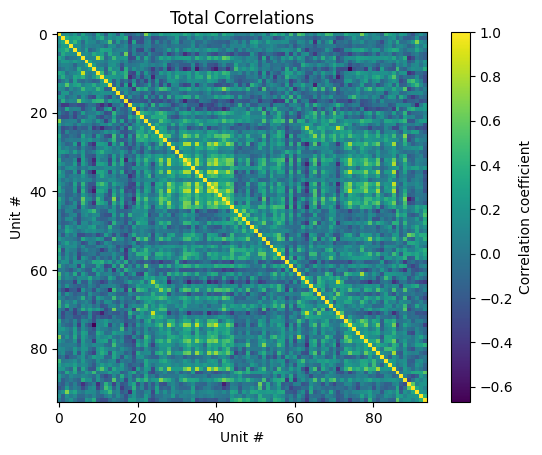

In [26]:
total_correlations = np.corrcoef(norm_firing_rates)
plt.imshow(total_correlations)
plt.colorbar(label='Correlation coefficient')
plt.title('Total Correlations')
plt.xlabel('Unit #')
plt.ylabel('Unit #')

Next, we'll compute the signal correlations. These are the correlations in the neurons' average response to each stimulus (defined by orientation), computed across stimuli. As the name implies, they tell us how much two neurons' mean (trial averaged) activities co-vary as the stimulus changes.

To compute these, we'll first calculate the average activities for each stimulus orientation and neuron, then compute the correlation matrix across stimuli.

Recall that each stimulus was presented 15 times, and we have ordered the stimuli by orientation.

Text(0, 0.5, 'Unit #')

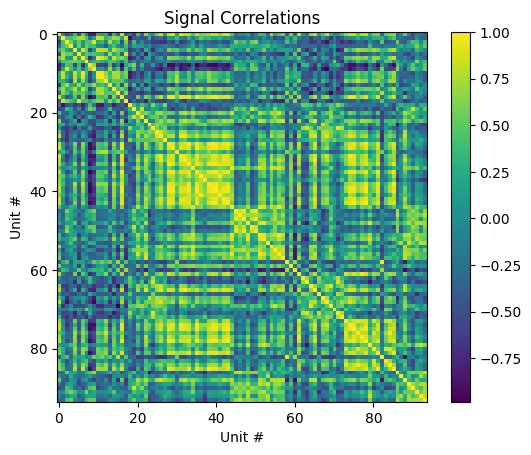

In [29]:
mean_resp = np.zeros([94,8]) #initialize our array of 94 neurons x 8 stimuli
for i in range(0,8):
    mean_resp[:,i] = np.mean(norm_firing_rates[:,i*15:i*15+15],axis=1) #mean firing rate for each unit, for each stimulus in sets of 15

signal_correlations = np.corrcoef(mean_resp)
plt.imshow(signal_correlations)
plt.colorbar()
plt.title('Signal Correlations')
plt.xlabel('Unit #')
plt.ylabel('Unit #')

Finally, let's compute the noise correlations. These are the correlations in the responses to each stimulus, reflecting the (correlated) trial-to-trial variability in the neural population. These correlations can come from synaptic connections (or indirect connections) between the neurons, so that when neuron A fires more on a given trial, neuron B also fires more (excitatory connection), or neuron B fires less (inhibitory connection). The noise correlations can also come from shared input. For example, if neuron C has an excitatory projection to both neurons A and B, then on trials where neuron C has increased firing rate, then both neurons A and B will also show increased firing.

These noise correlations are defined on a per-stimulus basis and can vary somewhat between stimuli. For sake of interest, we'll plot below the correlation matrices for two different stimuli, and we'll later make use of the average correlation matrix (averaged over all 8 orientations).

Text(0, 0.5, 'Unit #')

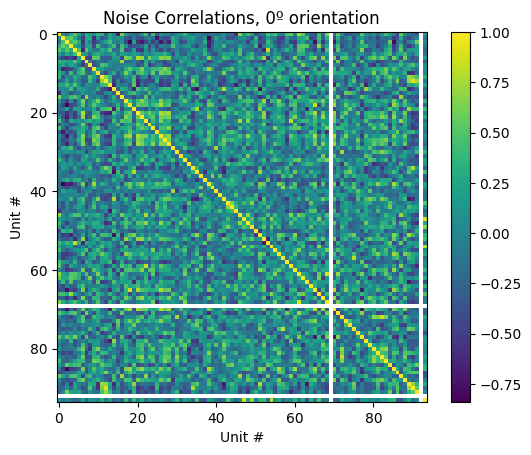

In [30]:
noise_correlations = np.zeros([94,94,8]) #initialize our array of correlation matrices for each stim direction
for i in range(0,8):
    noise_correlations[:,:,i] = np.corrcoef(norm_firing_rates[:,i*15:i*15+15]) #correlation matrix for each stimulus in sets of 15, i are the indexes of the stimuli trials 

plt.imshow(noise_correlations[:,:,0])
plt.colorbar()
plt.title('Noise Correlations, 0º orientation')
plt.xlabel('Unit #')
plt.ylabel('Unit #')

Text(0, 0.5, 'Unit #')

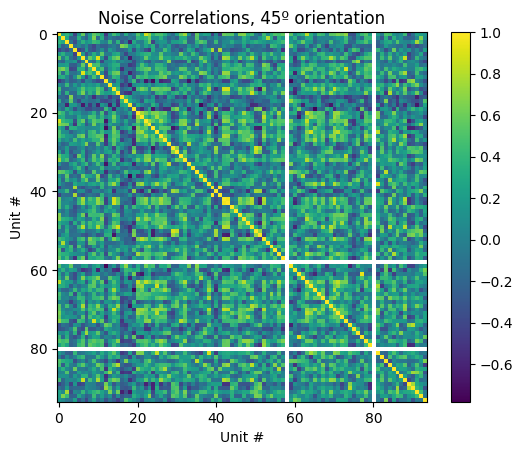

In [31]:
plt.imshow(noise_correlations[:,:,1])
plt.colorbar()
plt.title('Noise Correlations, 45º orientation')
plt.xlabel('Unit #')
plt.ylabel('Unit #')

Text(0, 0.5, 'Unit #')

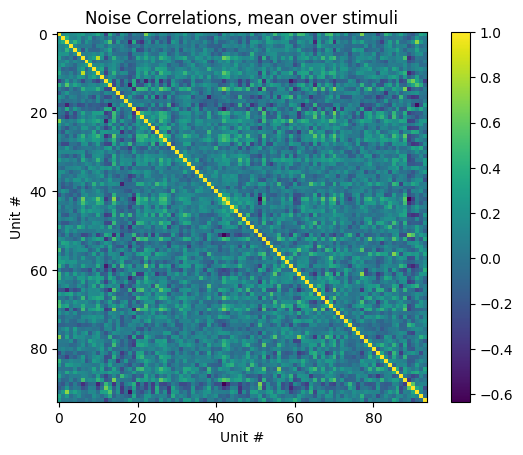

In [32]:
mean_noise_correlations = np.nanmean(noise_correlations,axis=2) #mean over stimuli with nanmean to ignore NaNs (which are caused by dividing by 0)
plt.imshow(mean_noise_correlations) #plot the mean noise correlations 
plt.colorbar()
plt.title('Noise Correlations, mean over stimuli')
plt.xlabel('Unit #')
plt.ylabel('Unit #')

A few things to note. 

First, the correlation coefficient is undefined (NaN) for any stimulus where one of the neurons in the pair doesn't spike at all. Those show up as missing rows/columns of the correlation matrix. When we average over stimuli, we use `numpy.nanmean` for this reason. That function takes the mean over all the non-NaN values. Otherwise, many pairs of neurons have undefined mean correlations.

Second, notice that the noise correlations can vary a lot between stimuli: the same neuron pair can be ~strongly correlated for one stimuli and anti-correlated for another stimulus.

Third, notice that the mean noise correlations are relatively weak, whereas the signal correlations can be much stronger (we show this explicitly in the cell below). This is typical for cortical recordings, although different results and be obtained in other parts of the nervous system. E.g., in retina, at lower light levels, noise correlations can be quite strong.

Finally, we'll compare the noise and signal correlations.

Mean Noise Correlation:
0.06461000054718673
Mean Signal Correlation:
0.11974658991734327


Text(0, 0.5, 'Noise Correlation')

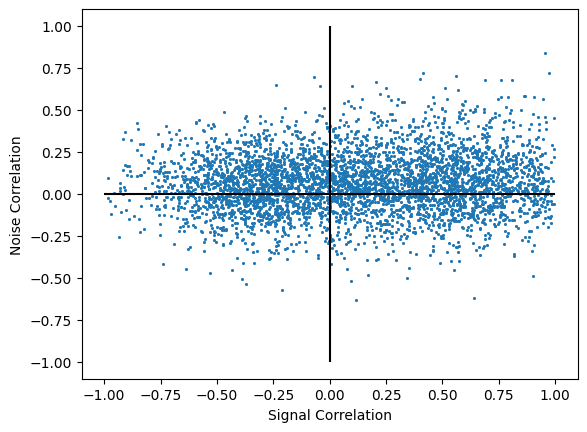

In [33]:
ncorr = np.matrix.flatten(mean_noise_correlations) #turns the noise correlation matrix into a vector 
indices = np.where(ncorr > 0.99) #remove the ones along the diagonal that are 1
ncorr = np.delete(ncorr, indices) #remove the ones along the diagonal to remove the 1 correlation of each neuron with itself

print('Mean Noise Correlation:') 
print(np.mean(ncorr)) #mean noise correlation 

scorr = np.matrix.flatten(signal_correlations) #turns the signal correlation matrix into a vector
scorr = np.delete(scorr,indices) #remove the ones along the diagonal to remove the 1 correlation of each neuron with itself

print('Mean Signal Correlation:')
print(np.mean(scorr))

plt.scatter(scorr,ncorr,s=1)
plt.hlines(0,-1,1,colors='black')
plt.vlines(0,-1,1,colors='black')
plt.xlabel('Signal Correlation')
plt.ylabel('Noise Correlation')

At first these look ~unrelated to each other! If we look closer, we'll note that there is a small (but statistically quite significant) trend for neuron pairs with higher signal correlation to have higher noise correlation, and vice versa.

For this, we'll use the scipy pearsonr function instead of numpy corrcoef, because it returns a p-value from the hypothesis test where the null hypothesis is zero correlation.

In [34]:
from scipy.stats.stats import pearsonr
pearsonr(ncorr,scorr)

PearsonRResult(statistic=0.08042854057843703, pvalue=5.031924396450127e-14)

While the relation is fairly weak, it is quite robust, and the existence of this positive relationship between signal and noise correlations rules out lots of computational models that made the opposite prediction. See, E.g., the local competition algorithm for implementing sparse coding, which was once a leading theory of V1 computation.

## Population decoding with and without noise correlations

While the noise correlations are fairly weak (averaging ~0.06), it is worth asking whether or not -- from an information processing standpoint -- we can treat each neuron as independent. In other words, are the noise correlations weak enough that they can be ignored?

To test this, we'll return to the decoding analysis from Tutorial 1, and we will try decoding the stimulus in two ways. First, we will decode from the true neural data, which contains the (weak) noise correlations. This is the same as we did in Tutorial 1, so feel free to jump ahead.

In [35]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

responses = norm_firing_rates.data.T
labels = presentations.orientation.values.astype('int')
conditions = np.unique(labels)

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.8333333333333334
0.75
0.75
0.9166666666666666
0.7916666666666666

mean accuracy: 0.8083333333333333
chance: 0.125


Next, for comparison, we will try decoding from synthetic data in which we artificially remove the noise correlations. We do this by trial-shuffling the neural data. This creates a fake dataset in which non-simultaneously-recorded neural activities are assembled to make the population response vectors, and it removes the noise correlations.

To do this, we go through the data, and for each stimulus, and for each neuron, we randomly (and independently) re-order the trials.

In [36]:
shuff_dat = np.zeros([94,120]) #initialize our array of 94 neurons x 120 trials
for i in range(0,8): #loop over all stimuli
    for neur in range(0,94): #loop over all neurons
        shuffled_indices = np.random.permutation(15)    
        shuff_dat[neur,i*15:i*15+15] = norm_firing_rates[neur,i*15 + shuffled_indices]                                                

As a quick check, we'll compute the noise correlations on the suffled data and check that they are indeed nearly zero. (Note: if you re-run the shuffle procedure in the above cell, and then re-run the noise correlation calculation below, you should get a slightly different, small mean noise correlation each time. These differences represent the randomness of the shuffling procedure).

In [37]:
shuff_noise_correlations = np.zeros([94,94,8]) #initialize our array of correlation matrices for each stim
for i in range(0,8):
    shuff_noise_correlations[:,:,i] = np.corrcoef(shuff_dat[:,i*15:i*15+15])

shuff_mean_noise_correlations = np.nanmean(shuff_noise_correlations,axis=2)

shuff_ncorr = np.matrix.flatten(shuff_mean_noise_correlations)
indices = np.where(shuff_ncorr > 0.99) #remove the ones along the diagonal
shuff_ncorr = np.delete(shuff_ncorr, indices)

print('Mean Shuff Noise Correlation:')
print(np.mean(shuff_ncorr))

Mean Shuff Noise Correlation:
-0.000987989234295336


The noise correlations in the shuffled data are indeed near zero (as expected). We can also check that the signal correlations are unaffected by the shuffle procedure:

In [38]:
mean_resp = np.zeros([94,8]) #initialize our array of 94 neurons x 8 stimuli
for i in range(0,8):
    mean_resp[:,i] = np.mean(shuff_dat[:,i*15:i*15+15],axis=1)

shuff_signal_correlations = np.corrcoef(mean_resp)
shuff_scorr = np.matrix.flatten(shuff_signal_correlations)
shuff_scorr = np.delete(shuff_scorr,indices)

print('Mean Shuff Signal Correlation:')
print(np.mean(shuff_scorr))

Mean Shuff Signal Correlation:
0.11974658991734324


Finally, let's see how removing the noise correlations affected the decodability:

In [39]:
responses = np.transpose(shuff_dat)
labels = presentations.orientation.values.astype('int')
conditions = np.unique(labels)

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.45833333333333337
0.8333333333333334
0.8333333333333334
0.7083333333333333
0.41666666666666663

mean accuracy: 0.6499999999999999
chance: 0.125


In this case, removing noise correlations has a fairly modest effect on decoding accuracy. In other cases, their impact can be quite strong: the effects depend sensitively on the structure of the signal and noise correlations, and this has been the topic of a lot of study!